In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from vnc_networks import MANC, Connections, params


In [41]:
# ----- Directories
manc_version = "v1.2"
MDN_DIR = "DNs_to_VNC"
FIG_DIR = MANC(manc_version).get_fig_dir()
MDN_FIGS = os.path.join(FIG_DIR, MDN_DIR)
os.makedirs(MDN_FIGS, exist_ok=True)


In [ ]:
savefigs = False  # True to save figures

# Are command-like DNs recruiting interlayer neurons with specific properties?

In [43]:
# Define a new connectome from which connections between motor neurons are removed
CR = MANC(manc_version)
vanilla_vnc = Connections(CR=CR)  # no neuron splitting or anything
mn_bids = vanilla_vnc.get_neuron_bodyids({"class_1": "motor"})
vnc_clean_mns = Connections(CR=CR, not_connected=mn_bids)

Attribute class_1 not found in the graph. Adding it.
Attribute class_1 not found in the graph. Adding it.


## Which neurons are reachable only in multiple hops from DNs, or not reachable at all

In [44]:
layer_df = pd.read_csv(
    os.path.join(FIG_DIR,"overall_VNC" , "layer_dict.csv"),
    )[["body_id", "layer"]]

In [45]:
vnc_clean_mns.include_node_attributes(
    attributes=["hemilineage", "nt_type", "target", "exit_nerve", "class_2"]
    )
nodes = layer_df["body_id"].to_list()
neuron_df = vnc_clean_mns.list_neuron_properties(neurons=nodes, input_type="body_id")

Attribute hemilineage not found in the graph. Adding it.
Attribute nt_type not found in the graph. Adding it.
Attribute target not found in the graph. Adding it.
Attribute exit_nerve not found in the graph. Adding it.
Attribute class_2 not found in the graph. Adding it.


In [46]:
# merge both on 'body_id'
layer_df = pd.merge(
    neuron_df,
    layer_df,
    on="body_id",
    how="inner",
)

In [47]:
def plot_neurons_per_out_layer(neuron_df, attribute):
    # For more visibility, keep only the last "weird" layers
    df = neuron_df[(neuron_df["layer"] >= 3) | (neuron_df["layer"] == -1)]

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create a countplot using seaborn, oriented vertically
    sns.countplot(
        data=df,
        x=attribute,
        hue="layer",
        palette=params.custom_palette,
    )
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90)

    # Set the title and labels
    plt.title(f"Number of Neurons per Layer and {attribute}")
    plt.xlabel(attribute)
    plt.ylabel("Number of Neurons")
    plt.legend(title="Layer")

    # Show the plot
    if savefigs:
        plt.savefig(os.path.join(MDN_FIGS, f"neurons_per_layer_out_of_range_{attribute}.pdf"))
    plt.show()

/tmp/ipykernel_10215/1441567822.py:9: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.countplot(


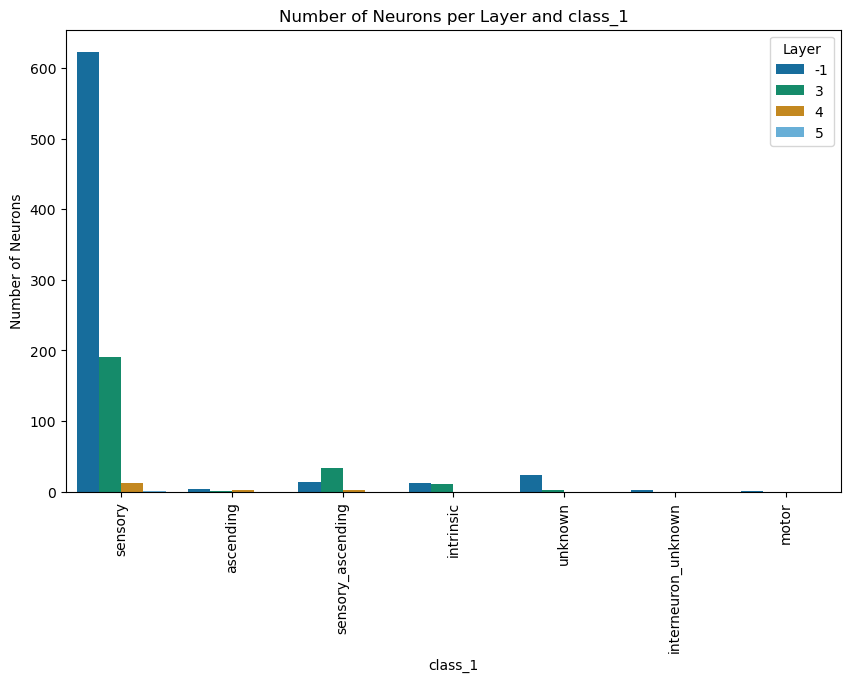

In [48]:
plot_neurons_per_out_layer(layer_df, attribute="class_1")


In [49]:
other_layers = layer_df[(layer_df["layer"] == -1) | (layer_df["layer"] >= 3)]
nb_sensory = len(other_layers[
    (other_layers["class_1"] == "sensory")
    | (other_layers["class_1"] == "sensory_ascending")
    ])
nb_tot = len(other_layers)
print(
    f"Out of the {nb_tot} neurons in higher layers or no layer, ",
    "\n",
    f"{nb_sensory} ( or {100 * nb_sensory / nb_tot:.2f} %) are sensory neurons. ",
)

Out of the 938 neurons in higher layers or no layer,  
 877 ( or 93.50 %) are sensory neurons. 


## Identify which neurons are at distance 2 from DNs but not motor neurons

In [50]:
def plot_neurons_layer_2(neuron_df, attribute, cutoff=1, ref_df=None):
    # For more visibility, keep only the last "weird" layers
    df = neuron_df[
        (neuron_df["layer"] == 2)
        & ~(neuron_df["class_1"] == "motor")
        ]
    
    # get the attribute values for which there are at least 5 neurons
    if cutoff != 0:
        counts = df[attribute].value_counts()
        cut = cutoff / 100 * len(df)
        # Filter the DataFrame to include only those values
        df_ = df[df[attribute].isin(counts[counts >= cut].index)]
    else:
        df_ = df.copy()
    
    # Sort the dataframe by attribute value counts usch that the first bar is the highest
    sorted_counts = df_[attribute].value_counts().sort_values(ascending=False)
    sorted_values = sorted_counts.index
    df_[attribute] = pd.Categorical(df_[attribute], categories=sorted_values, ordered=True)
    # Reset the index of the DataFrame
    df_.reset_index(drop=True, inplace=True)

    if ref_df is not None:
        # For the reference DataFrame, filter to include only those values
        counts_ref = ref_df[attribute].value_counts()
        cut = cutoff / 100 * len(ref_df)
        # Filter the DataFrame to include only those values
        ref_df = ref_df[ref_df[attribute].isin(counts_ref[counts_ref >= cut].index)]
        
        # Sort the reference dataframe by attribute value counts usch that the first bar is the highest
        sorted_counts_ref = ref_df[attribute].value_counts().sort_values(ascending=False)
        sorted_values_ref = sorted_counts_ref.index
        ref_df[attribute] = pd.Categorical(ref_df[attribute], categories=sorted_values_ref, ordered=True)
        # Reset the index of the DataFrame
        ref_df.reset_index(drop=True, inplace=True)

    # Set the figure size
    if ref_df is None:
        plt.subplots(1,1,figsize=(10, 6))
    
        # Create a countplot using seaborn, oriented vertically
        sns.countplot(
            data=df_,
            x=attribute,
            hue="class_1",
            palette=params.custom_palette,
        )
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=90)

        # Set the title and labels
        plt.title(f"Number of Neurons per class and {attribute}")
        plt.xlabel(attribute)
        plt.ylabel("Number of Neurons")
        plt.legend(title="class")

    else:
        # Create a countplot using seaborn, oriented vertically
        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        sns.countplot(
            data=df_,
            x=attribute,
            hue="class_1",
            palette=params.custom_palette,
            ax=axs[0]
        )
        sns.countplot(
            data=ref_df,
            x=attribute,
            hue="class_1",
            palette=params.custom_palette,
            ax=axs[1]
        )
        for ax in axs:
            ax.set_xlabel(attribute)
            ax.set_ylabel("Number of Neurons")
            ax.legend(title="class")
            ax.tick_params(axis="x", rotation=90)
        axs[0].set_title(f"Number of Neurons per class and {attribute} in layer 2")
        axs[1].set_title(f"Number of Neurons per class and {attribute} in all interneurons")
        plt.tight_layout()



    # Show the plot
    if savefigs:
        plt.savefig(
            os.path.join(MDN_FIGS, f"neurons_non-mns_in_layer_2_{attribute}.pdf")
        )
    plt.show()


/tmp/ipykernel_10215/549420204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[attribute] = pd.Categorical(df_[attribute], categories=sorted_values, ordered=True)
/tmp/ipykernel_10215/549420204.py:43: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.countplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


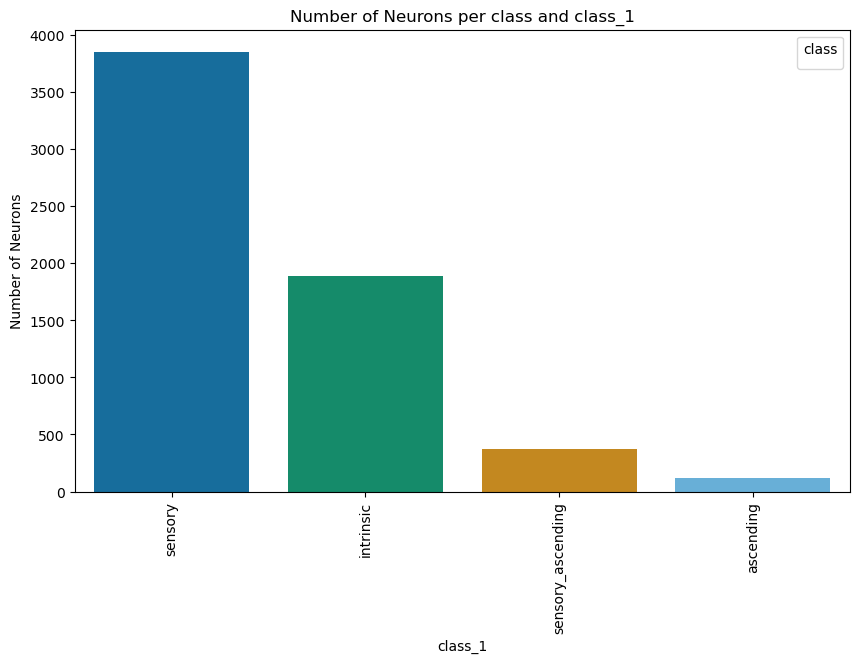

Out of the 6261 neurons in layer 2 that are not motor neurons,  
 4229 ( or 67.55 %) are sensory neurons. 


In [51]:
plot_neurons_layer_2(layer_df, "class_1")
layer_2 = layer_df[(layer_df["layer"] == 2) & ~(layer_df["class_1"] == "motor")]
nb_sensory = len(
    layer_2[
        (layer_2["class_1"] == "sensory") | (layer_2["class_1"] == "sensory_ascending")
    ]
)
nb_tot = len(layer_2)
print(
    f"Out of the {nb_tot} neurons in layer 2 that are not motor neurons, ",
    "\n",
    f"{nb_sensory} ( or {100 * nb_sensory / nb_tot:.2f} %) are sensory neurons. ",
)

In [52]:
layer_2 = layer_2[layer_2["class_1"] == "intrinsic"]
ref_df = neuron_df[neuron_df["class_1"] == "intrinsic"] # all intrinsic neurons

/tmp/ipykernel_10215/549420204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[attribute] = pd.Categorical(df_[attribute], categories=sorted_values, ordered=True)
/tmp/ipykernel_10215/549420204.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[attribute] = pd.Categorical(ref_df[attribute], categories=sorted_values_ref, ordered=True)
/tmp/ipykernel_10215/549420204.py:61: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.countplot(
/tmp/ipyk

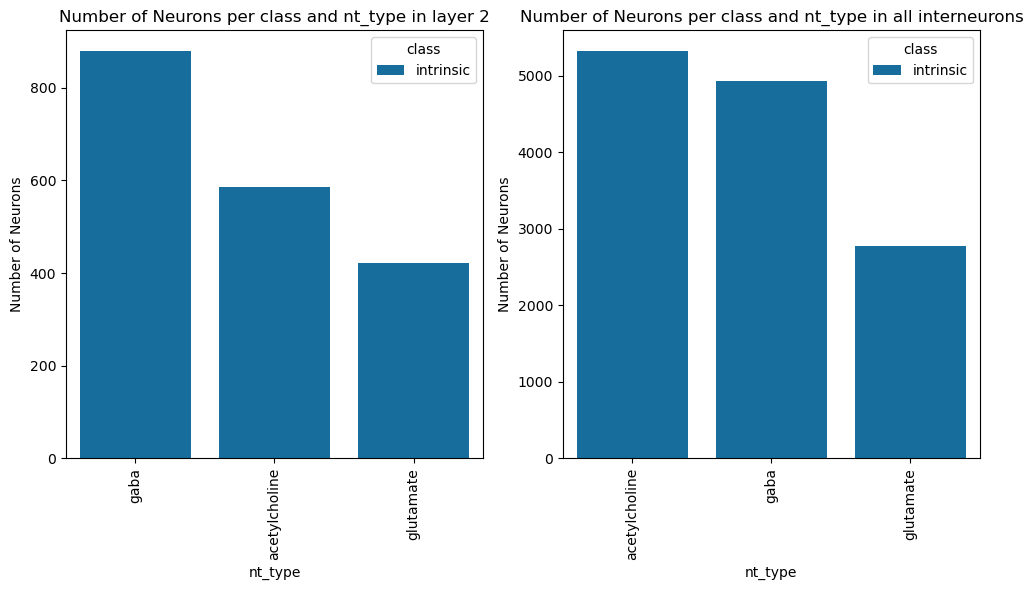

Out of the 1888 intrinsic neurons in layer 2,  
 880 ( or 46.61 %) are GABAergic neurons. 
This is different from the 13040 intrinsic neurons in the whole VNC,  
 4930 ( or 37.81 %) are GABAergic neurons. 


In [53]:
plot_neurons_layer_2(layer_2, "nt_type", ref_df=ref_df)
print(
    f"Out of the {len(layer_2)} intrinsic neurons in layer 2, ",
    "\n",
    f"{len(layer_2[layer_2['nt_type'] == 'gaba'])} ( or {100 * len(layer_2[layer_2['nt_type'] == 'gaba']) / len(layer_2):.2f} %) are GABAergic neurons. ",
)
print(
    f"This is different from the {len(ref_df)} intrinsic neurons in the whole VNC, ",
    "\n",
    f"{len(ref_df[ref_df['nt_type'] == 'gaba'])} ( or {100 * len(ref_df[ref_df['nt_type'] == 'gaba']) / len(ref_df):.2f} %) are GABAergic neurons. ",
    )

# Compared to all intrinsic neurons

/tmp/ipykernel_10215/549420204.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[attribute] = pd.Categorical(ref_df[attribute], categories=sorted_values_ref, ordered=True)
/tmp/ipykernel_10215/549420204.py:61: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.countplot(
/tmp/ipykernel_10215/549420204.py:68: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.countplot(


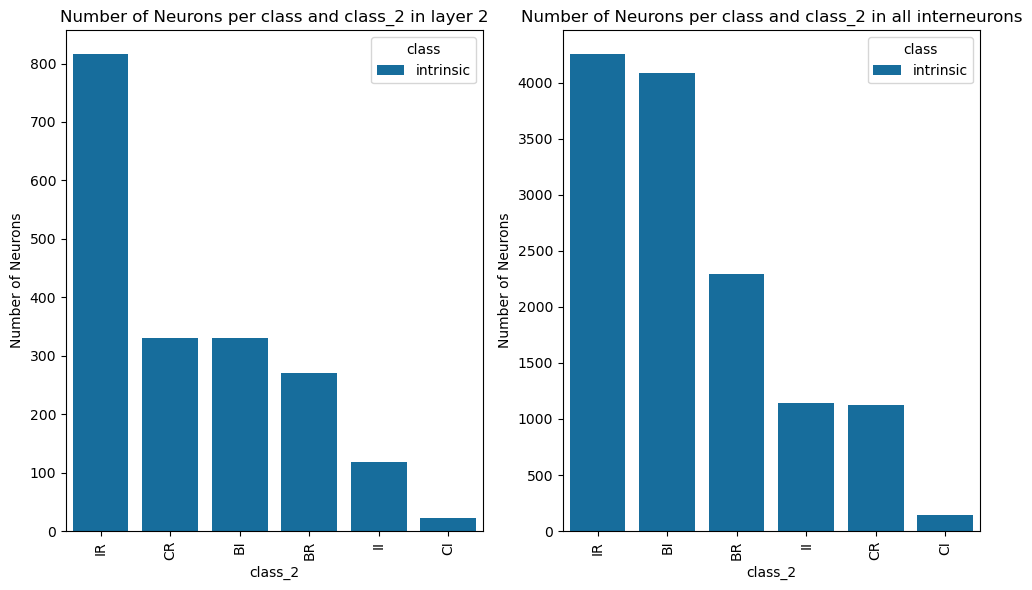

In [54]:
plot_neurons_layer_2(layer_2, "class_2", ref_df=ref_df)


/tmp/ipykernel_10215/549420204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[attribute] = pd.Categorical(df_[attribute], categories=sorted_values, ordered=True)
/tmp/ipykernel_10215/549420204.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[attribute] = pd.Categorical(ref_df[attribute], categories=sorted_values_ref, ordered=True)
/tmp/ipykernel_10215/549420204.py:61: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.countplot(
/tmp/ipyk

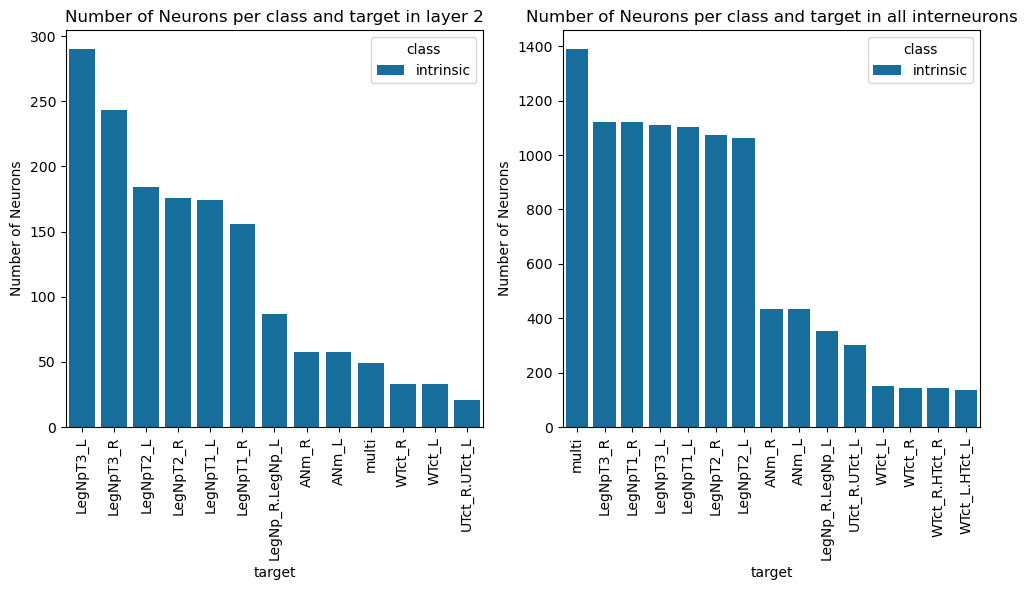

In [55]:
plot_neurons_layer_2(layer_2, "target", ref_df=ref_df)


/tmp/ipykernel_10215/549420204.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[attribute] = pd.Categorical(df_[attribute], categories=sorted_values, ordered=True)
/tmp/ipykernel_10215/549420204.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df[attribute] = pd.Categorical(ref_df[attribute], categories=sorted_values_ref, ordered=True)
/tmp/ipykernel_10215/549420204.py:61: UserWarning: The palette list has more values (7) than needed (1), which may not be intended.
  sns.countplot(
/tmp/ipyk

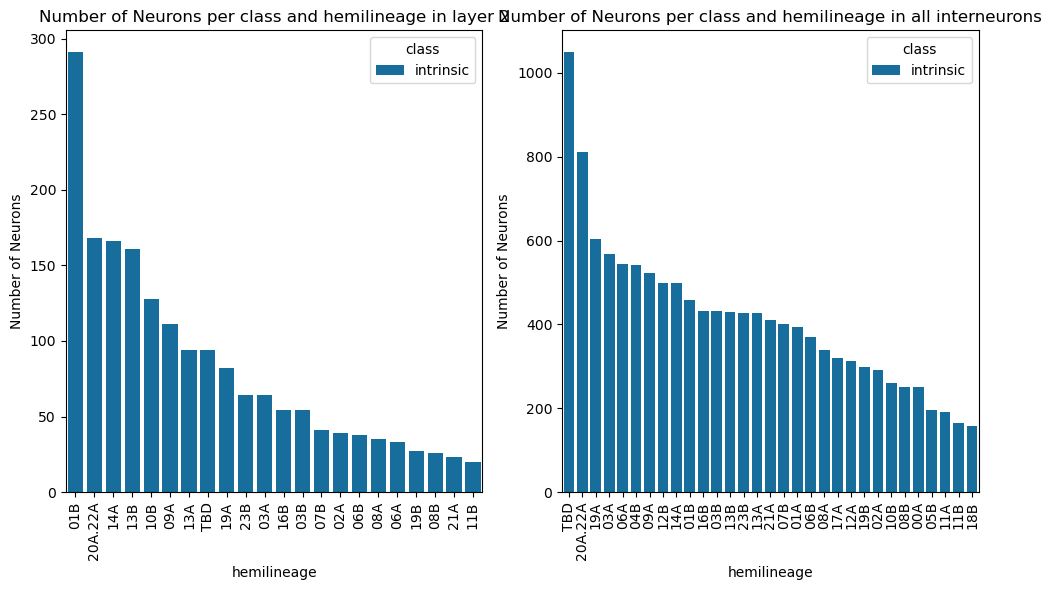

In [56]:
plot_neurons_layer_2(layer_2, "hemilineage", ref_df=ref_df)


Observations:
- 67 % of neurons that are at distance 2 from DNs but not motor neurons are sensory neurons, complementing the fact that 93% of the neurons assigned to higher or no layers are sensory neurons as well (including sensory ascending in the def.)
- This means that roughly 2000 (1888) intrinsic neurons are not premotor neurons, and nothing else.
    - of those 2000, there is a overrepresentation of gabaergic neurons with 46.6 %, compared to 37.8 % in the whole population.
    - the layer 2 intrinsic neurons are mostly ipsilaterally restricted, and are in the leg neuropil circuitry.